In [104]:
import glob
import os
import os.path as osp
import pickle
import random
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

import datasets.dataset as dataset
from datasets.dataset import load_data, CLASS_MAP
import models.models as models
from utils.data_class import BrainDataset
import torchio as tio
#from models.models import Vgg16, FujiNet1

SEED_VALUE = 2481
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

In [105]:
#!nvidia-smi

In [106]:
os.environ["CUDA_VISIBLE_DEVICES"]="6"
#この環境変数は最初に宣言しないと有効にならない

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [108]:
# dataset ADNI2-2, PPMI, OASIS, 

dataset = load_data(kinds=["ADNI2"], classes=["CN", "AD"], unique=True)
# dataset = load_data(kinds=["PPMI"], classes=["Control"], unique=True)
# dataset = load_data(kinds=["OASIS"], classes=["Control"], unique=True)
len(dataset)

255

In [109]:
# trainとtest用の画像を、同じ患者が分かれて入らないように分ける。

from sklearn.model_selection import GroupShuffleSplit, train_test_split

# train_datadict, val_datadict = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

pids = []
for i in range(len(dataset)):
    pids.append(dataset[i]["pid"])
gss = GroupShuffleSplit(test_size=1-0.8, random_state=SEED_VALUE)
train_idx, val_idx = list(gss.split(dataset, groups=pids))[0]
train_datadict = dataset[train_idx]
val_datadict = dataset[val_idx]

len(train_datadict)

204

In [110]:
# TorchIO
class ImageTransformio():
    def __init__(self):
        self.transform = {
            "train": tio.Compose([
                tio.transforms.RandomAffine(scales=(0.9, 1.2), degrees=10, isotropic=True,
                                 center="image", default_pad_value="mean", image_interpolation='linear'),
                # tio.transforms.RandomNoise(),
                # tio.transforms.RandomBiasField(),
                # tio.ZNormalization(),
                tio.transforms.RescaleIntensity((0, 1))
            ]),
            "val": tio.Compose([
                # tio.ZNormalization(),
                # tio.RescaleIntensity((0, 1))  # , in_min_max=(0.1, 255)),
            ])
        }

    def __call__(self, img, phase="train"):
        img_t = torch.tensor(img)
        return self.transform[phase](img_t)

In [111]:
# train/val dataset を作成
train_dataset = BrainDataset(data_dict=train_datadict, transform=ImageTransformio(), phase="train")
val_dataset = BrainDataset(data_dict=val_datadict, transform=ImageTransformio(), phase="val")

print("size of the training dataset = ", len(train_dataset))
print("size of the validation dataset = ", len(val_dataset))
print("training image shape = {}, training label = {}".format(train_dataset(0)[0].shape, train_dataset(0)[1]))
print("test image shape = {}, test label = {}".format(val_dataset(0)[0].shape, val_dataset(0)[1]))

size of the training dataset =  204
size of the validation dataset =  51
training image shape = torch.Size([1, 80, 96, 80]), training label = 0
test image shape = torch.Size([1, 80, 96, 80]), test label = 0


mean= tensor(0.0802)
max=1.0 min=0.0
0


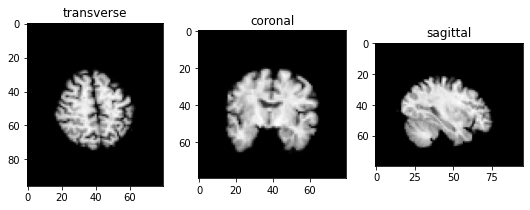

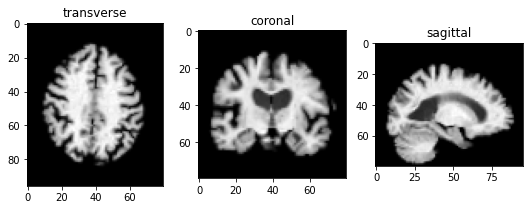

In [112]:
# 画像可視化関数
def show_slice(gazo):

    def _voxel2slice(voxel: np.array, aspect: str, slice_idx: int) -> np.array:
        if aspect == 'sagittal':
            slice_img = np.flip(voxel.transpose((0, 2, 1))[slice_idx], 0)
        elif aspect == 'coronal':
            slice_img = np.flip(voxel.transpose((1, 2, 0))[slice_idx], 0)
        elif aspect == 'transverse':
            slice_img = np.flip(voxel.transpose((2, 1, 0))[slice_idx], 0)
        return slice_img

    fig = plt.figure(figsize=(9,3))
    trans = fig.add_subplot(1, 3, 1)
    trans.set_title("transverse", fontsize=12)
    trans.imshow(_voxel2slice(gazo, 'transverse', 50), cmap='gray')
    coronal = fig.add_subplot(1, 3, 2)
    coronal.set_title("coronal", fontsize=12)
    coronal.imshow(_voxel2slice(gazo, 'coronal', 50), cmap='gray')
    sagittal = fig.add_subplot(1, 3, 3)
    sagittal.set_title("sagittal", fontsize=12)
    sagittal.imshow(_voxel2slice(gazo, 'sagittal', 50), cmap='gray')

    fig.show()


idx = 20
img1, label1 = train_dataset(idx)
img2, label2 = train_dataset(idx+1)

print("mean=", img1.mean())
print(f"max={img1.max()} min={img1.min()}")
print(label1)

show_slice(img1.numpy().reshape(80, 96, 80))
show_slice(img2.numpy().reshape(80, 96, 80))

#imge = np.clip(image, 0, None)
# print(img1.numpy().reshape(80, 80, 80).mean())
# plt.imshow(np.flip(img1.numpy().reshape(80, 80, 80).transpose(2,0,1)[50],0), cmap="gray")
# plt.imshow(np.flip(img2.numpy().reshape(80, 80, 80).transpose(2,0,1)[50],0), cmap="gray")

mean= tensor(0.1568)
max=1.0 min=0.0
0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


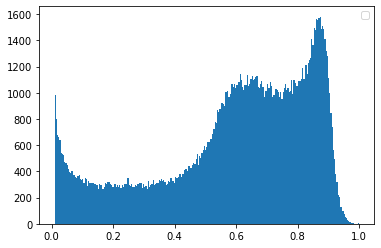

In [113]:
# 画像１枚あたりの輝度値ヒストグラム
idx = 20
image, label = train_dataset(idx)
print("mean=", image.mean())
print(f"max={image.max()} min={image.min()}")
print(label)
#imge = np.clip(image, 0, None)
show_img = image.numpy().reshape(80*96*80)
plt.hist(show_img[show_img > 0.01], bins=255)
#plt.title("Accuracy")
#plt.xlabel("Epoch")
#plt.ylabel("Accuracy")
plt.legend()

255


(array([202052., 172694., 151746., 138417., 127822., 120465., 112777.,
        107473., 102649.,  99161.,  95582.,  92724.,  89344.,  86860.,
         83594.,  81014.,  79649.,  78156.,  76775.,  74802.,  74023.,
         72905.,  72345.,  70484.,  69943.,  69239.,  68728.,  68115.,
         67491.,  67165.,  67318.,  68053.,  67720.,  68201.,  69435.,
         70097.,  71726.,  73413.,  75179.,  76855.,  78554.,  80545.,
         82244.,  83854.,  85371.,  85829.,  86217.,  86970.,  86560.,
         85786.,  85940.,  85783.,  84074.,  83569.,  82192.,  82002.,
         81060.,  80743.,  78770.,  78519.,  77187.,  76350.,  75441.,
         74922.,  74208.,  73158.,  71882.,  71749.,  71425.,  71623.,
         70963.,  70854.,  70710.,  70308.,  69935.,  70368.,  71087.,
         70442.,  71023.,  70791.,  70983.,  71354.,  71935.,  72229.,
         72745.,  72979.,  73270.,  73919.,  74126.,  74575.,  75461.,
         76280.,  76356.,  77325.,  77420.,  78398.,  79319.,  80361.,
      

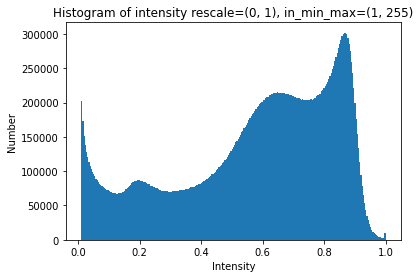

In [114]:
image_list = []
max = 0.01
for image, label in train_dataset:
    if max < image.max():
        max = image.max()
    image_reshape = image.numpy().reshape(80*96*80)
    image_list.append(image_reshape)

for image, label in val_dataset:
    if max < image.max():
        max = image.max()
    image_reshape = image.numpy().reshape(80*96*80)
    image_list.append(image_reshape)
print(len(image_list))

imagelist = np.concatenate(image_list)
plt.title("Histogram of intensity rescale=(0, 1), in_min_max=(1, 255)")
plt.xlabel("Intensity")
plt.ylabel("Number")
plt.hist(imagelist[imagelist > 0.01], bins=255)

In [115]:
print(max)

tensor(1.)


In [116]:
# 画像の定量評価
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

idx = 20
img1, label1 = train_dataset(idx)
img2, label2 = train_dataset(idx+1)
img1 = np.flip(img1.numpy().reshape(80, 96, 80).transpose(2,0,1)[50],0)
img2 = np.flip(img2.numpy().reshape(80, 96, 80).transpose(2,0,1)[50],0)

mse_none = mean_squared_error(img1, img2)
ssim_none = ssim(img1, img2)

print(ssim_none)

0.6190846597288374


In [117]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

for inputs, labels in train_dataloader:
    print(labels)

tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1])
tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0])
tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])
tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0])
tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1])
tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0])
tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1])
tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0])


In [118]:
#net = models.MyVgg16()
net = models.FujiNet1()
print(net)

FujiNet1(
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv3d(1, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(3, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=64000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm3d1): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3d12): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3d2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3d3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch

In [119]:
torch.nn.init.kaiming_normal(net.conv1.weight)
torch.nn.init.kaiming_normal(net.conv2.weight)
torch.nn.init.kaiming_normal(net.conv3.weight)
torch.nn.init.kaiming_normal(net.conv4.weight)
torch.nn.init.kaiming_normal(net.fc1.weight)
torch.nn.init.kaiming_normal(net.fc2.weight)

/tmp/ipykernel_1885872/1588208921.py:1: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(net.conv1.weight)
/tmp/ipykernel_1885872/1588208921.py:2: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(net.conv2.weight)
/tmp/ipykernel_1885872/1588208921.py:3: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(net.conv3.weight)
/tmp/ipykernel_1885872/1588208921.py:4: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(net.conv4.weight)
/tmp/ipykernel_1885872/1588208921.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  torch.nn.init.kaiming_normal(net.fc1.weight)
/tmp/ipykernel_1885872/1588208921.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor

Parameter containing:
tensor([[-0.1058,  0.0241,  0.1178,  ...,  0.0386, -0.0371,  0.1262],
        [-0.0058,  0.0135,  0.0386,  ..., -0.0583,  0.0081, -0.0624]],
       requires_grad=True)

In [120]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(params=net.parameters(), lr=0.0005, momentum=0.9)
optimizer = optim.Adam(params=net.parameters(), lr=0.001)

In [121]:
def train_model(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    print("Use divice = ", device)

    for epoch in range(num_epochs):
        # train
        net.train()
        loss_avg = 0.0
        acc_avg = 0.0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            acc_avg += torch.mean((preds == labels).float()).item() / len(train_dataloader)
            loss_avg += loss.item() / len(train_dataloader)
        train_losses.append(loss_avg)
        train_accs.append(acc_avg)

        # evaluate
        loss_avg = 0.0 
        acc_avg = 0.0
        net.eval()
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = net(inputs)
                loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            acc_avg += torch.mean((preds == labels).float()).item() / len(val_dataloader)
            loss_avg += loss.item() / len(val_dataloader)

        test_losses.append(loss_avg)
        test_accs.append(acc_avg)
        print(f"EPOCH {epoch+1}  || train loss : {train_losses[epoch]:.4f}, test loss : {test_losses[epoch]:.4f} \
            || train acc : {train_accs[epoch]:.4f} || test acc : {test_accs[epoch]:.4f}")

In [122]:
num_epochs = 100

train_losses = []
test_losses = []
train_accs = []
test_accs = []

train_model(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

Use divice =  cuda


RuntimeError: shape '[-1, 64000]' is invalid for input of size 1228800

In [ ]:
plt.plot(range(100), train_losses, label="train loss")
plt.plot(range(100), test_losses, label="test loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()